In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os


!pip install -U torchvision > /dev/null

In [2]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# remove arnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [4]:
from albumentations.pytorch import ToTensorV2

In [5]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(320, 320), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='albumentations'))
    else:
        transform = A.Compose([
            A.Resize(320, 320), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='albumentations'))
    return transform

In [6]:
class FishDataset(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):

        self.transforms = transforms

        self.root = os.path.join(root, split)
        self.images = sorted(os.listdir(os.path.join(root, split, 'images')))
        self.labels = sorted(os.listdir(os.path.join(root, split, 'labels')))

    def _load_image(self, id:int):
        image = cv2.imread(os.path.join(self.root, 'images', self.images[id]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    
    def _load_label(self, id:int):
        label = open(os.path.join(self.root, 'labels', self.labels[id])).readlines()
        return label


    def __len__(self):
        return len(self.images)

    def __getitem__(self, id):

        image = self._load_image(id)
        label = self._load_label(id)

        height, width, _ = image.shape

        bbox = [] # [[xmin, ymin, xmax, ymax], ... ]
        for line in label:
            
            splited = line.strip().split()

            cx = float(splited[1])
            cy = float(splited[2])
            w = float(splited[3]) 
            h = float(splited[4])

            bbox.append([max(cx-w/2, 0), max(cy-h/2, 0), min(cx+w/2, 1), min(cy+h/2, 1), 1])

        bbox = torch.Tensor(bbox)
        transformed = self.transforms(image=image, bboxes=bbox)

        image = transformed['image']
        new_bbox = []
        for box in transformed['bboxes']:
            
            min_x = box[0] * width
            min_y = box[1] * height
            max_x = box[2] * width
            max_y = box[3] * height
            
            new_bbox.append([min_x, min_y, max_x, max_y])   
        
        boxes = torch.tensor(new_bbox, dtype=torch.float32)

        target = {}

         # here is our transformed target
        target['boxes'] = boxes
        target['labels'] = torch.tensor([1 for i in range(len(bbox))], dtype=torch.int64)
        target['image_id'] = id
        if len(boxes) > 0:
            target['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        else:
            target['area'] = 0
            target['boxes'] = torch.zeros((0,4),dtype=torch.float32)
        target['iscrowd'] = torch.zeros((len(boxes),), dtype=torch.int64)
        
        return image.div(255), target # scale images


In [7]:
train_dataset = FishDataset(root='/kaggle/input/fish-v10/fishes', transforms=get_transforms(True))

In [8]:
len(train_dataset)

31987

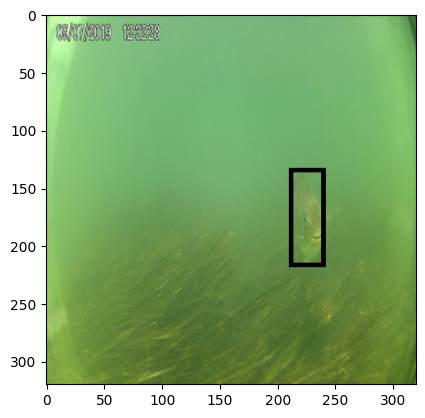

In [9]:
sample = train_dataset[5000]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(
    draw_bounding_boxes(
        img_int, 
        sample[1]['boxes'], 
        width=4
).permute(1, 2, 0))

In [10]:
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)

in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, 2)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 123MB/s]


In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [12]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [13]:
images, targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Tesla P100-PCIE-16GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [15]:
model = model.to(device)

In [16]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [17]:
import sys

In [18]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)
        
#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)
    
    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
#         if lr_scheduler is not None:
#             lr_scheduler.step() # 
        
    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [19]:
num_epochs=30

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
#     lr_scheduler.step()

100%|██████████| 7997/7997 [22:25<00:00,  5.94it/s]


Epoch 0, lr: 0.010000, loss: 0.568695, loss_classifier: 0.220615, loss_box: 0.298963, loss_rpn_box: 0.015783, loss_object: 0.033334


100%|██████████| 7997/7997 [15:24<00:00,  8.65it/s]


Epoch 1, lr: 0.010000, loss: 0.595662, loss_classifier: 0.230087, loss_box: 0.324875, loss_rpn_box: 0.014419, loss_object: 0.026281


100%|██████████| 7997/7997 [14:59<00:00,  8.89it/s]


Epoch 2, lr: 0.010000, loss: 0.606015, loss_classifier: 0.233138, loss_box: 0.333841, loss_rpn_box: 0.014047, loss_object: 0.024989


100%|██████████| 7997/7997 [14:53<00:00,  8.95it/s]


Epoch 3, lr: 0.010000, loss: 0.614295, loss_classifier: 0.235791, loss_box: 0.341193, loss_rpn_box: 0.013800, loss_object: 0.023511


100%|██████████| 7997/7997 [14:55<00:00,  8.93it/s]


Epoch 4, lr: 0.010000, loss: 0.614214, loss_classifier: 0.235180, loss_box: 0.341853, loss_rpn_box: 0.013722, loss_object: 0.023459


100%|██████████| 7997/7997 [14:52<00:00,  8.96it/s]


Epoch 5, lr: 0.010000, loss: 0.619664, loss_classifier: 0.237056, loss_box: 0.346345, loss_rpn_box: 0.013591, loss_object: 0.022673


100%|██████████| 7997/7997 [14:48<00:00,  9.00it/s]


Epoch 6, lr: 0.010000, loss: 0.620177, loss_classifier: 0.237430, loss_box: 0.347377, loss_rpn_box: 0.013509, loss_object: 0.021861


100%|██████████| 7997/7997 [14:42<00:00,  9.06it/s]


Epoch 7, lr: 0.010000, loss: 0.615167, loss_classifier: 0.234832, loss_box: 0.344777, loss_rpn_box: 0.013369, loss_object: 0.022189


100%|██████████| 7997/7997 [14:50<00:00,  8.98it/s]


Epoch 8, lr: 0.010000, loss: 0.620130, loss_classifier: 0.236603, loss_box: 0.348610, loss_rpn_box: 0.013341, loss_object: 0.021577


100%|██████████| 7997/7997 [14:45<00:00,  9.03it/s]


Epoch 9, lr: 0.010000, loss: 0.620305, loss_classifier: 0.235925, loss_box: 0.349804, loss_rpn_box: 0.013302, loss_object: 0.021275


100%|██████████| 7997/7997 [14:42<00:00,  9.06it/s]


Epoch 10, lr: 0.010000, loss: 0.616860, loss_classifier: 0.234490, loss_box: 0.347998, loss_rpn_box: 0.013203, loss_object: 0.021169


100%|██████████| 7997/7997 [14:39<00:00,  9.10it/s]


Epoch 11, lr: 0.010000, loss: 0.615271, loss_classifier: 0.233395, loss_box: 0.347540, loss_rpn_box: 0.013231, loss_object: 0.021105


100%|██████████| 7997/7997 [14:33<00:00,  9.15it/s]


Epoch 12, lr: 0.010000, loss: 0.623147, loss_classifier: 0.236846, loss_box: 0.352343, loss_rpn_box: 0.013166, loss_object: 0.020792


100%|██████████| 7997/7997 [14:27<00:00,  9.22it/s]


Epoch 13, lr: 0.010000, loss: 0.620070, loss_classifier: 0.235043, loss_box: 0.351475, loss_rpn_box: 0.013064, loss_object: 0.020488


100%|██████████| 7997/7997 [14:24<00:00,  9.25it/s]


Epoch 14, lr: 0.010000, loss: 0.619110, loss_classifier: 0.235285, loss_box: 0.350433, loss_rpn_box: 0.013071, loss_object: 0.020320


100%|██████████| 7997/7997 [14:30<00:00,  9.19it/s]


Epoch 15, lr: 0.010000, loss: 0.622751, loss_classifier: 0.236075, loss_box: 0.353186, loss_rpn_box: 0.013070, loss_object: 0.020420


100%|██████████| 7997/7997 [14:33<00:00,  9.15it/s]


Epoch 16, lr: 0.010000, loss: 0.618640, loss_classifier: 0.234206, loss_box: 0.351020, loss_rpn_box: 0.013008, loss_object: 0.020407


100%|██████████| 7997/7997 [14:48<00:00,  9.00it/s]


Epoch 17, lr: 0.010000, loss: 0.618297, loss_classifier: 0.234569, loss_box: 0.349770, loss_rpn_box: 0.013116, loss_object: 0.020842


100%|██████████| 7997/7997 [14:32<00:00,  9.16it/s]


Epoch 18, lr: 0.010000, loss: 0.621315, loss_classifier: 0.234951, loss_box: 0.353665, loss_rpn_box: 0.012897, loss_object: 0.019803


100%|██████████| 7997/7997 [14:32<00:00,  9.16it/s]


Epoch 19, lr: 0.010000, loss: 0.614974, loss_classifier: 0.233442, loss_box: 0.348273, loss_rpn_box: 0.012949, loss_object: 0.020310


100%|██████████| 7997/7997 [14:30<00:00,  9.19it/s]


Epoch 20, lr: 0.010000, loss: 0.619279, loss_classifier: 0.234542, loss_box: 0.352007, loss_rpn_box: 0.012892, loss_object: 0.019839


100%|██████████| 7997/7997 [14:31<00:00,  9.18it/s]


Epoch 21, lr: 0.010000, loss: 0.617712, loss_classifier: 0.233926, loss_box: 0.351036, loss_rpn_box: 0.012816, loss_object: 0.019934


100%|██████████| 7997/7997 [14:33<00:00,  9.15it/s]


Epoch 22, lr: 0.010000, loss: 0.620788, loss_classifier: 0.234258, loss_box: 0.353972, loss_rpn_box: 0.012835, loss_object: 0.019723


100%|██████████| 7997/7997 [14:32<00:00,  9.17it/s]


Epoch 23, lr: 0.010000, loss: 0.619796, loss_classifier: 0.234589, loss_box: 0.352352, loss_rpn_box: 0.012897, loss_object: 0.019957


100%|██████████| 7997/7997 [14:30<00:00,  9.19it/s]


Epoch 24, lr: 0.010000, loss: 0.624888, loss_classifier: 0.237092, loss_box: 0.355512, loss_rpn_box: 0.012768, loss_object: 0.019517


100%|██████████| 7997/7997 [14:23<00:00,  9.27it/s]


Epoch 25, lr: 0.010000, loss: 0.618400, loss_classifier: 0.233083, loss_box: 0.352689, loss_rpn_box: 0.012867, loss_object: 0.019760


100%|██████████| 7997/7997 [14:32<00:00,  9.17it/s]


Epoch 26, lr: 0.010000, loss: 0.620954, loss_classifier: 0.234882, loss_box: 0.353952, loss_rpn_box: 0.012776, loss_object: 0.019344


100%|██████████| 7997/7997 [14:26<00:00,  9.23it/s]


Epoch 27, lr: 0.010000, loss: 0.619020, loss_classifier: 0.233812, loss_box: 0.352899, loss_rpn_box: 0.012767, loss_object: 0.019542


100%|██████████| 7997/7997 [14:26<00:00,  9.23it/s]


Epoch 28, lr: 0.010000, loss: 0.621320, loss_classifier: 0.234759, loss_box: 0.354435, loss_rpn_box: 0.012697, loss_object: 0.019428


100%|██████████| 7997/7997 [14:31<00:00,  9.18it/s]


Epoch 29, lr: 0.010000, loss: 0.621553, loss_classifier: 0.234791, loss_box: 0.354394, loss_rpn_box: 0.012747, loss_object: 0.019622


In [20]:
test_dataset = FishDataset(root='/kaggle/input/fish-v10/fishes', split="test", transforms=get_transforms(False))

In [21]:
model.eval()
torch.cuda.empty_cache()

In [22]:
img, _ = test_dataset[5]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

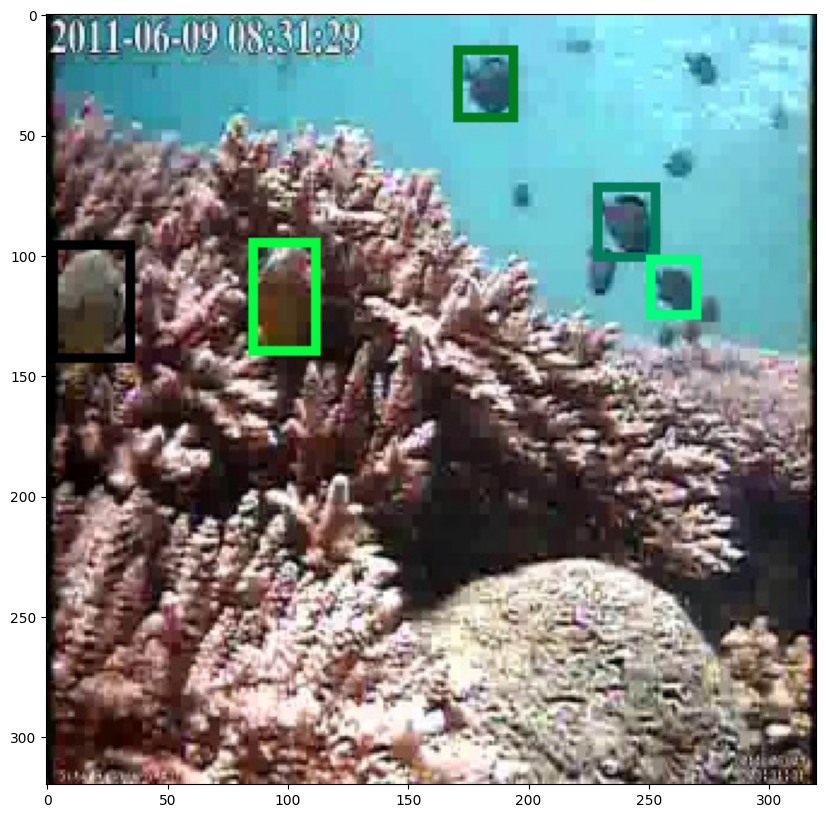

In [23]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(
    draw_bounding_boxes(
        img_int, 
        pred['boxes'][pred['scores'] > 0.8], 
        width=4
).permute(1, 2, 0))

In [24]:
torch.save(model.state_dict(), 'model.pth')

In [25]:
print(all_losses_dict)

NameError: name 'all_losses_dict' is not defined